# Examen práctico 
## Parcial 4 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from lightgbm import LGBMRegressor, LGBMClassifier, early_stopping, log_evaluation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def calibracion(probabilidades, y_test):
    df_calibracion = pd.DataFrame({
        'probabilidades':probabilidades,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['probabilidades'], q=15, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure()
    plt.plot(grouped.probabilidades, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.probabilidades, grouped.probabilidades, label="Real", marker="o", color=colors[1])
    plt.xlabel("Probabilidad")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.legend()
    plt.show()

def histograma(probabilidades, y_test):
     df = pd.DataFrame({
     'real': y_test,
     'probabilidades': probabilidades
     })

     plt.figure()
     plt.hist(df[df.real == 1]['probabilidades'], density=True, color=colors[0], alpha=0.5, label = '1')
     plt.hist(df[df.real == 0]['probabilidades'], density=True, color=colors[1], alpha=0.5, label = '0')
     plt.title(f'Histograma de probabilidades')
     plt.xlabel("Probabilidad")
     plt.ylabel(" ")
     plt.legend()
     plt.show()

def roc(probabilidades, y_test):
     fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
     plt.figure()
     plt.plot(fpr, fnp, color=colors[0], lw=2)
     plt.plot([0, 1], [0, 1], color=colors[1], linestyle='--', lw=2, label='Clasificador aleatorio')
     plt.xlabel('1 - Specificity')
     plt.ylabel('Sensitivity')
     plt.title('ROC curve')
     plt.legend()
     plt.show()

def loss(train_loss, test_loss):
    plt.figure()
    plt.plot(train_loss, label='train', color=colors[0])
    plt.plot(test_loss, label='test', color=colors[1])
    plt.title('Loss')
    plt.xlabel('Iteración')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

def importance(features, importances, n_var, importance_type):
    model_importance = pd.DataFrame({
          'Variable': features,
          'Importancia': importances
    })
    model_importance = model_importance.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importancia", y="Variable", data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importancia"]):
          plt.text(value - 0.001, index, f"{value:.4f}", va="center", ha='right')
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_importance["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes tipo {importance_type}')
    plt.show()

def lightgbm(X_train, X_test, y_train, y_test):
    model = LGBMClassifier(num_iterations=10000, num_leaves=10, learning_rate=0.1, max_depth=6, lambda_l2=0.1, 
                           subsample=0.5, feature_fraction=0.8, verbosity=-1, metric=['auc', 'binary_logloss']
                           )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              callbacks=[early_stopping(20), log_evaluation(100)])
    
    probabilidades = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
    gini = 2*auc - 1

    calibracion(probabilidades, y_test)
    roc(probabilidades, y_test)
    histograma(probabilidades, y_test)

    train_loss = model.evals_result_['training']['binary_logloss']
    test_loss = model.evals_result_['valid_1']['binary_logloss']

    loss(train_loss, test_loss)

    importancia_split = model.booster_.feature_importance(importance_type='split')
    importancia_gain = model.booster_.feature_importance(importance_type='gain')
    features = model.booster_.feature_name()

    importance(features, importancia_split, 5, 'split')
    importance(features, importancia_gain, 5, 'gain')

    print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

    return model

def n_principal_components(X, n_var):
     pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('pca', PCA())
          ])

     pipeline.fit(X)

     objeto_pca = pipeline.named_steps['pca']
     X_pca = pipeline.transform(X)
     X_componentes = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

     varianza = [objeto_pca.explained_variance_ratio_[i] for i in range(n_var)]

     plt.bar(range(1, n_var+1), objeto_pca.explained_variance_ratio_[:n_var], color=colors[0])
     for i in range (n_var):
          plt.text(i+1, objeto_pca.explained_variance_ratio_[i] - 0.01, f'{objeto_pca.explained_variance_ratio_[i]:.4f}', ha='center', va='center', fontweight='bold')
     plt.xlabel('Componentes principales')
     plt.ylabel('Varianza explicada')
     plt.title(f'Varianza explicada de los {n_var} componentes principales ({sum(varianza):.2%})')
     plt.show()

     return X_componentes

def codo(data):
    data = data.copy().dropna()

    inertias = []
    for i in range(1, 11):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('kmeans', KMeans(n_clusters=i, random_state=42))
        ])
        pipeline.fit(data)
        inertias.append(pipeline.named_steps['kmeans'].inertia_)

    plt.figure()
    plt.plot(inertias, marker='o', color = colors[0])
    plt.title('Método del codo')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.show()

def clusters(data, clusters):
     data = data.copy().dropna()
     pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('kmeans', KMeans(n_clusters=clusters, random_state=42))
     ])
     pipeline.fit(data)
     data['cluster'] = pipeline.predict(data)

     return data

def shap_plot(X_test, model, n_var):
    X_shap = X_test.sample(int(len(X_test)*0.8), random_state=42)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)

    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=n_var)
    plt.show()

    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="dot", max_display=n_var)
    plt.show()

# Parte 1 - HR

## Data

In [3]:
data = pd.read_csv('Data/hr_role.csv')
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})
data = pd.get_dummies(data)
data.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1,1102,1,2,2,94,3,2,5993,...,False,False,True,False,False,False,True,True,False,True
1,49,0,279,8,1,3,61,2,2,5130,...,False,True,False,False,False,True,False,True,True,False
2,37,1,1373,2,2,4,92,2,1,2090,...,False,False,False,False,False,False,True,True,False,True
3,33,0,1392,3,4,4,56,3,1,2909,...,False,True,False,False,False,True,False,True,False,True
4,27,0,591,2,1,1,40,3,1,3468,...,False,False,False,False,False,True,False,True,True,False


### Variable dependiente

In [4]:
target = 'Attrition'
y = data[target]

### Variables independientes

In [5]:
X = data.copy().drop(target, axis=1)

## PCA

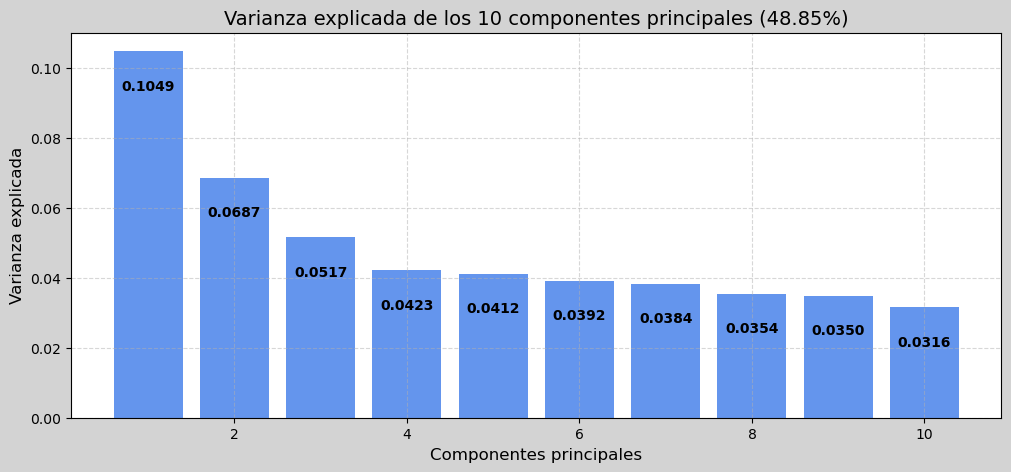

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
0,-0.030304,2.330446,-1.161395,3.217517,-0.113925,-0.253495,-1.040500,-0.309246,-0.448044,-2.111620,...,0.014891,7.021017e-16,-4.196757e-16,1.557119e-15,-6.386010e-16,4.196947e-16,-4.439226e-16,-4.944891e-16,-2.552172e-16,-1.479499e-16
1,0.049651,-1.543678,-0.213908,-1.662470,0.719564,2.208041,1.095471,1.080794,2.427347,-1.248215,...,-0.102855,-3.506487e-16,-5.087771e-16,-4.860947e-16,1.069790e-15,5.818953e-16,4.751109e-16,1.562116e-16,1.214602e-16,2.081245e-16
2,-2.921983,-0.996320,-0.206778,1.584724,-0.095803,-0.098296,-2.782596,-0.838934,0.416457,0.642975,...,-0.099216,7.298573e-16,-6.972314e-16,6.689407e-16,8.046889e-16,1.085828e-15,-1.221079e-15,-8.830672e-16,5.590343e-16,6.847174e-16
3,-1.187400,-1.054261,-0.692836,2.306721,-0.228501,2.392424,1.058589,0.071526,-1.843889,-1.818120,...,0.045951,-8.036383e-16,-1.377243e-15,1.390586e-15,9.157112e-16,-2.464391e-16,9.993673e-16,-1.105112e-15,5.210812e-16,3.794060e-16
4,-2.122667,-1.196360,0.532758,-1.288092,-0.694017,-1.685820,-0.501539,-0.272690,-0.631277,1.714992,...,0.148985,-1.841152e-16,4.210346e-16,-4.305835e-16,7.058972e-17,-5.648298e-17,3.102173e-17,-1.009523e-15,4.840632e-16,-1.249424e-16


In [6]:
X_componentes = n_principal_components(X, 10)
X_componentes.head()

## KMeans

### Codo

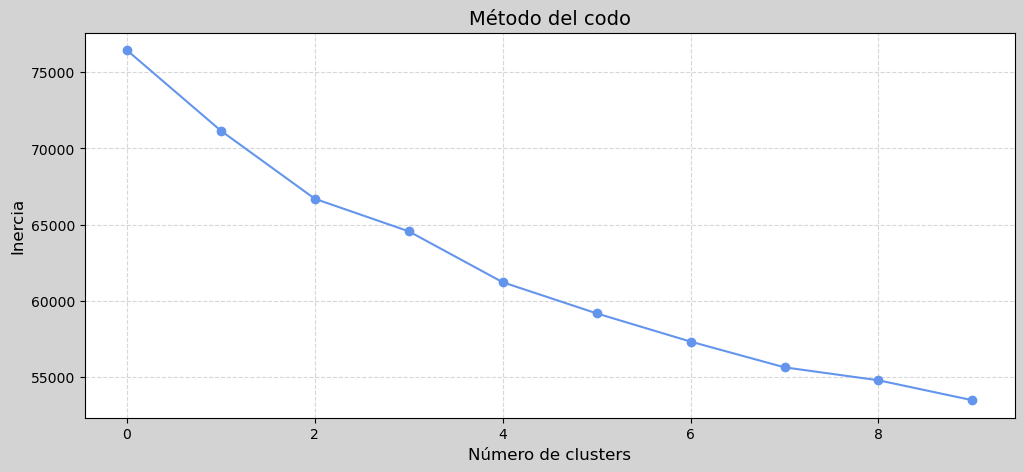

In [7]:
codo(data)

### Clusterización

In [8]:
data = clusters(data, 3)
data.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes,cluster
0,41,1,1102,1,2,2,94,3,2,5993,...,False,True,False,False,False,True,True,False,True,0
1,49,0,279,8,1,3,61,2,2,5130,...,True,False,False,False,True,False,True,True,False,2
2,37,1,1373,2,2,4,92,2,1,2090,...,False,False,False,False,False,True,True,False,True,2
3,33,0,1392,3,4,4,56,3,1,2909,...,True,False,False,False,True,False,True,False,True,2
4,27,0,591,2,1,1,40,3,1,3468,...,False,False,False,False,True,False,True,True,False,2


### Análisis clusters

In [9]:
data.groupby('cluster').mean()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
cluster,,,,,,,,,,,,,,,,,,,,,
0,35.150376,0.220551,800.052632,9.388471,2.912281,2.679198,65.192982,2.696742,2.035088,5911.969925,...,0.00000,0.000000,0.786967,0.20802,0.195489,0.453634,0.350877,1.0,0.709273,0.290727
1,45.957529,0.054054,809.146718,8.976834,3.100386,2.698842,66.030888,2.733591,3.884170,14807.872587,...,0.30888,0.003861,0.046332,0.00000,0.247104,0.505792,0.247104,1.0,0.698842,0.301158
2,34.913793,0.166256,801.556650,9.165025,2.853448,2.750000,66.189655,2.745074,1.497537,4144.327586,...,0.00000,0.358374,0.000000,0.00000,0.227833,0.444581,0.327586,1.0,0.726601,0.273399


In [10]:
data.groupby('cluster').count()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
cluster,,,,,,,,,,,,,,,,,,,,,
0,399,399,399,399,399,399,399,399,399,399,...,399,399,399,399,399,399,399,399,399,399
1,259,259,259,259,259,259,259,259,259,259,...,259,259,259,259,259,259,259,259,259,259
2,812,812,812,812,812,812,812,812,812,812,...,812,812,812,812,812,812,812,812,812,812


## Modelos

### Variables

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	training's auc: 0.992755	training's binary_logloss: 0.147445	valid_1's auc: 0.78009	valid_1's binary_logloss: 0.322332


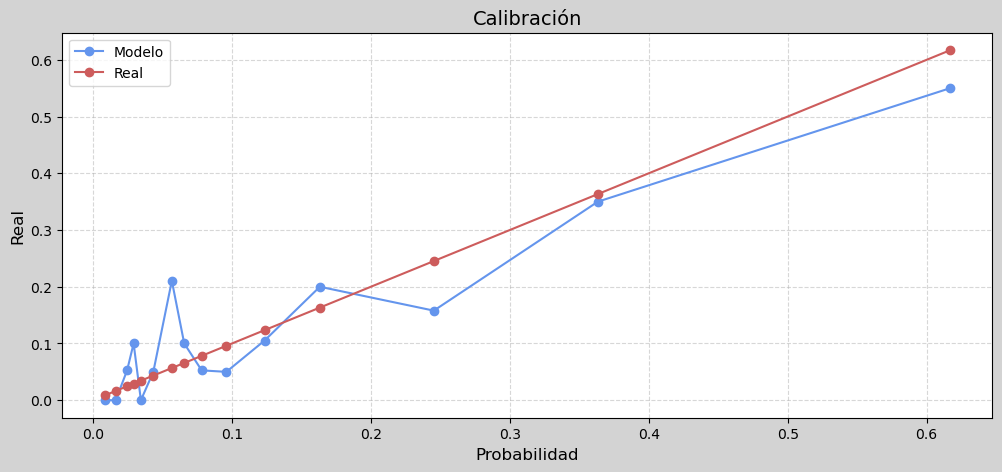

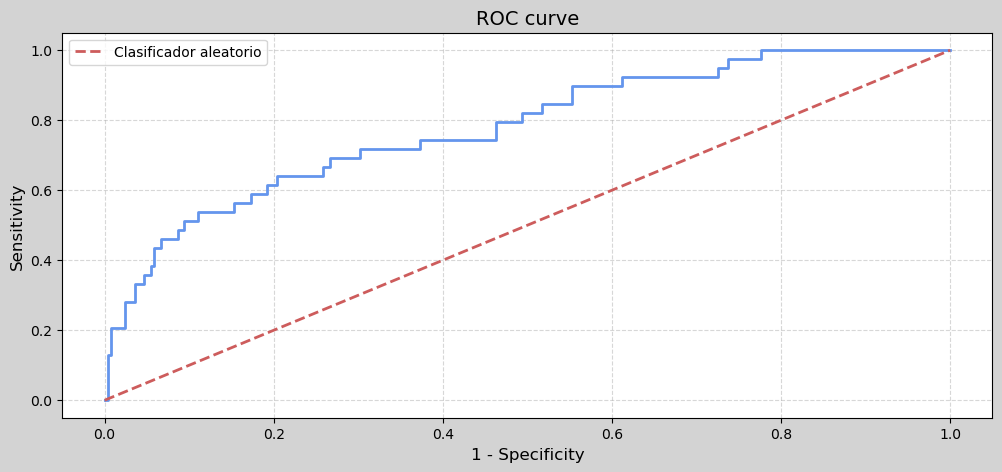

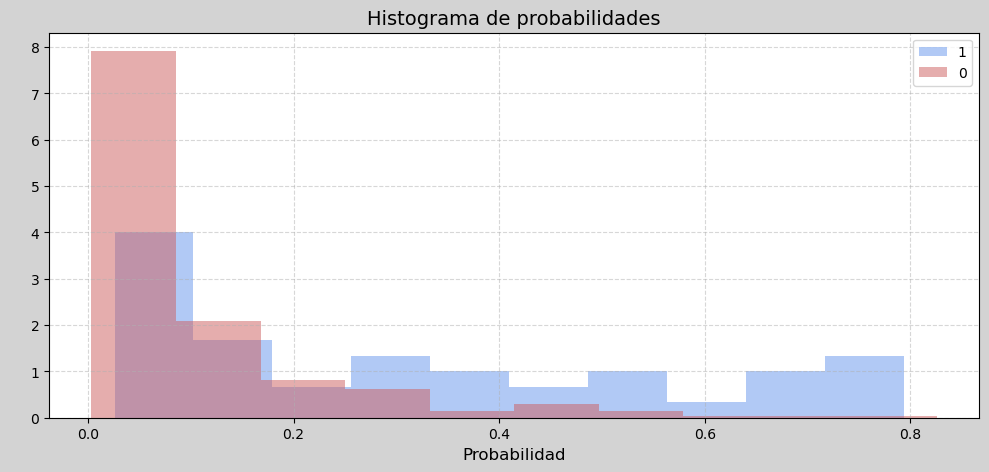

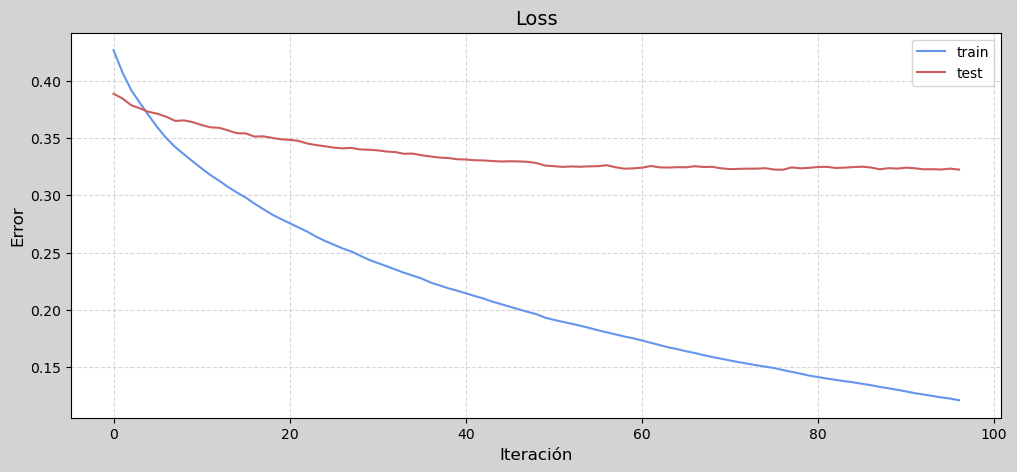

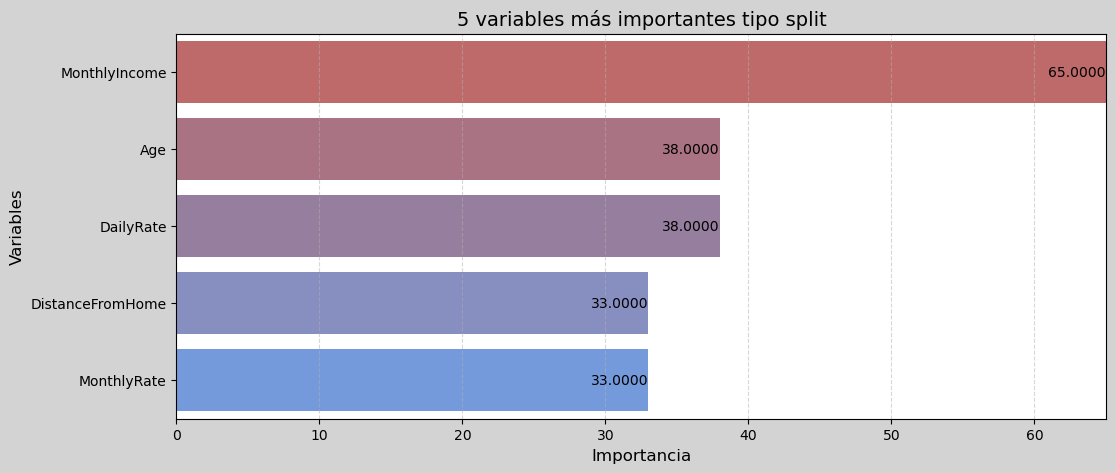

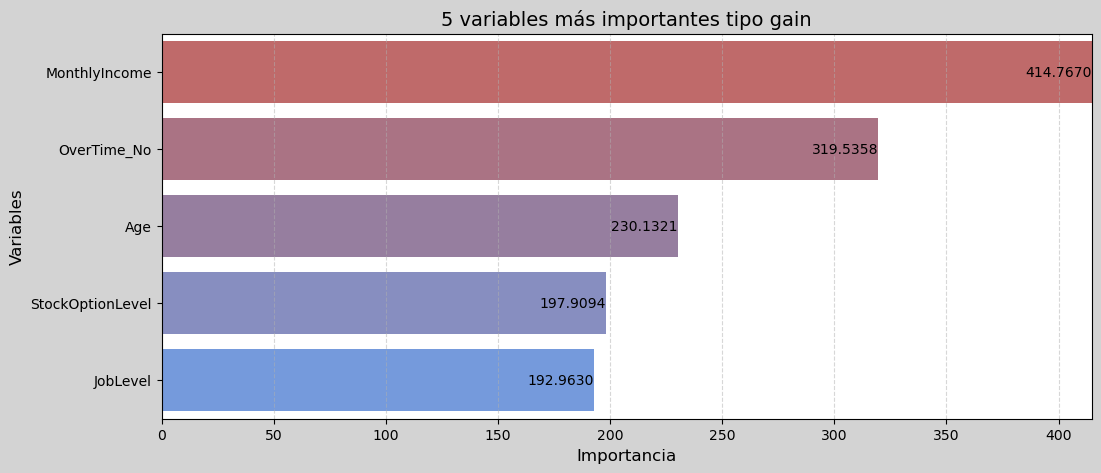

AUC: 0.7801
Gini: 0.5602


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lightgbm(X_train, X_test, y_train, y_test)

#### Shap Values

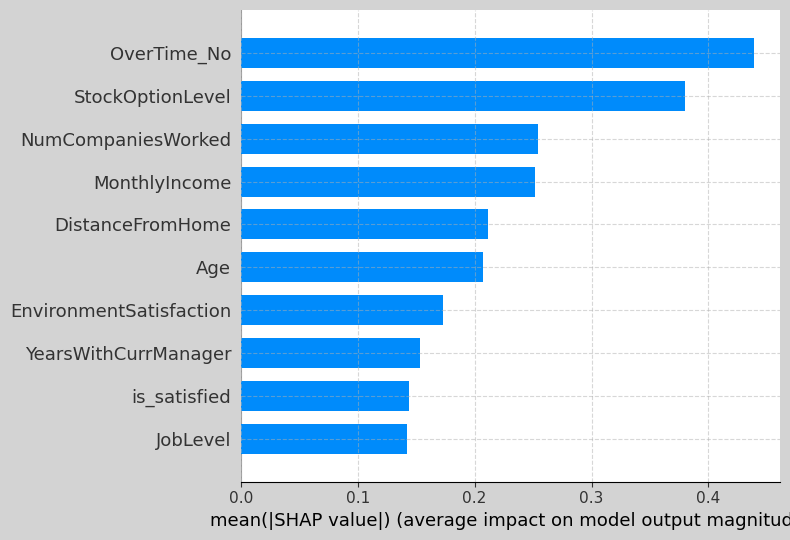

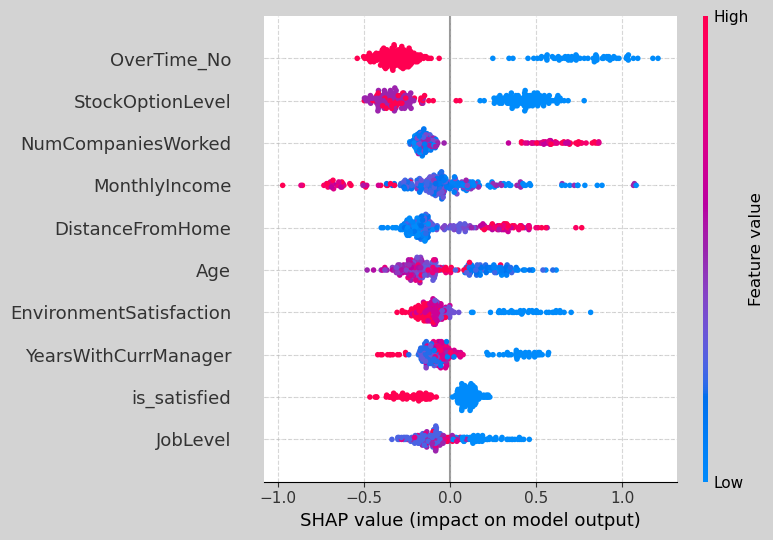

In [12]:
shap_plot(X_test, model, 10)

### Componentes

#### Todos los componentes

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.988876	training's binary_logloss: 0.192967	valid_1's auc: 0.774661	valid_1's binary_logloss: 0.321013


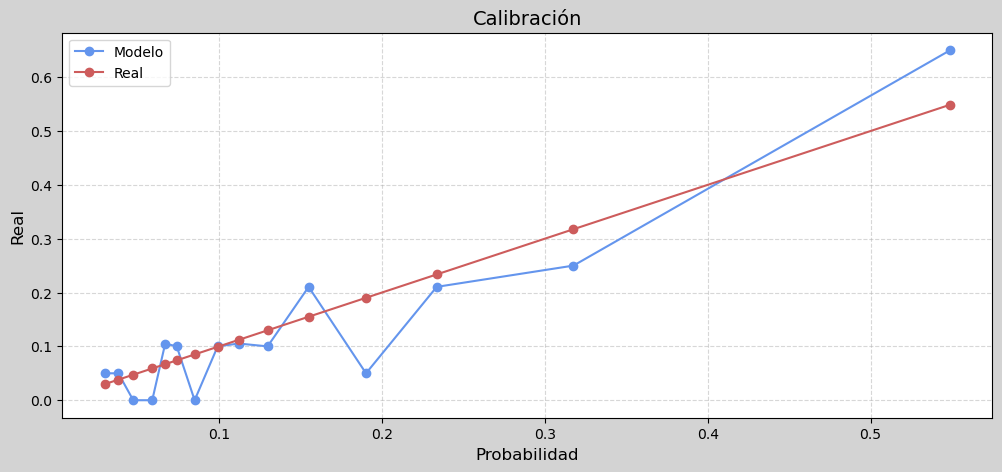

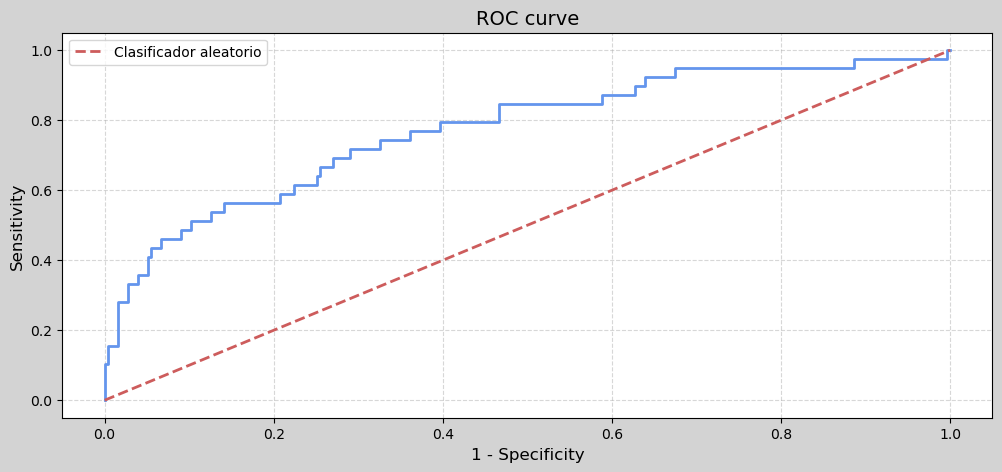

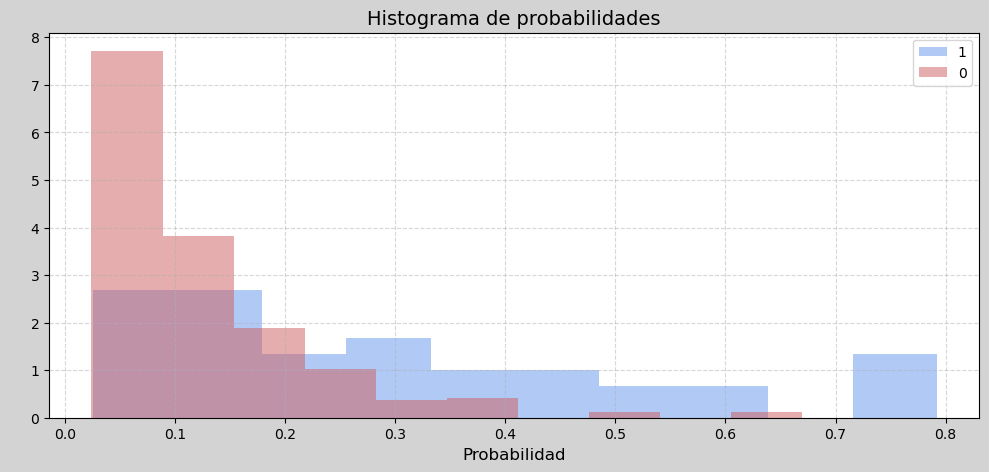

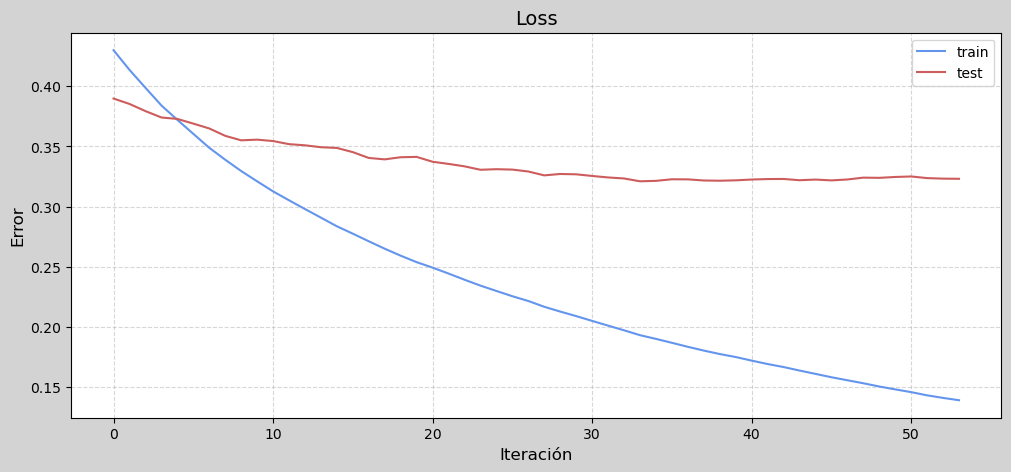

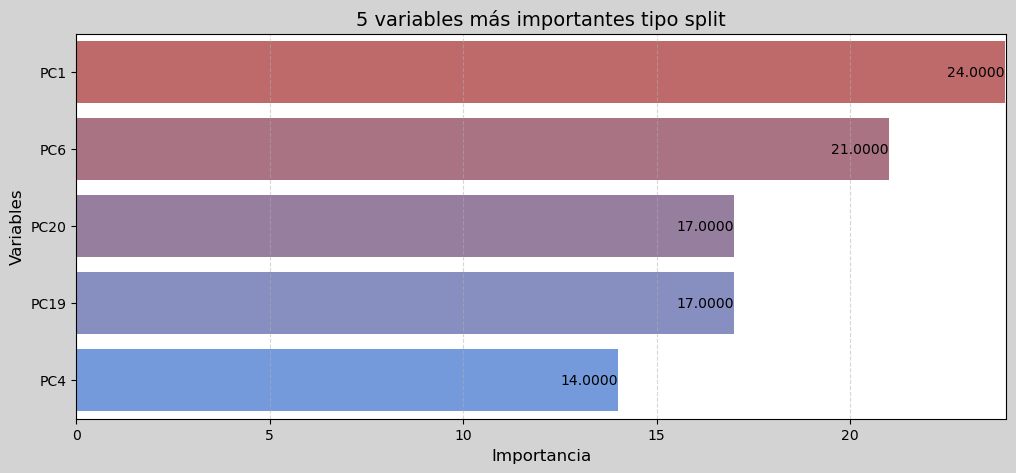

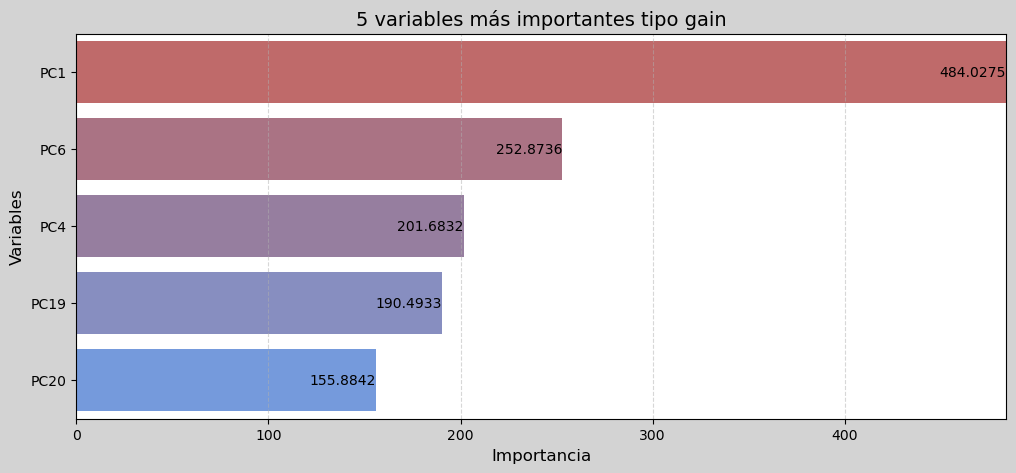

AUC: 0.7747
Gini: 0.5493


In [13]:
XC_train, XC_test, y_train, y_test = train_test_split(X_componentes, y, test_size=0.2, random_state=42)

model = lightgbm(XC_train, XC_test, y_train, y_test)

#### Componentes principales

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.834428	training's binary_logloss: 0.381923	valid_1's auc: 0.666566	valid_1's binary_logloss: 0.375664


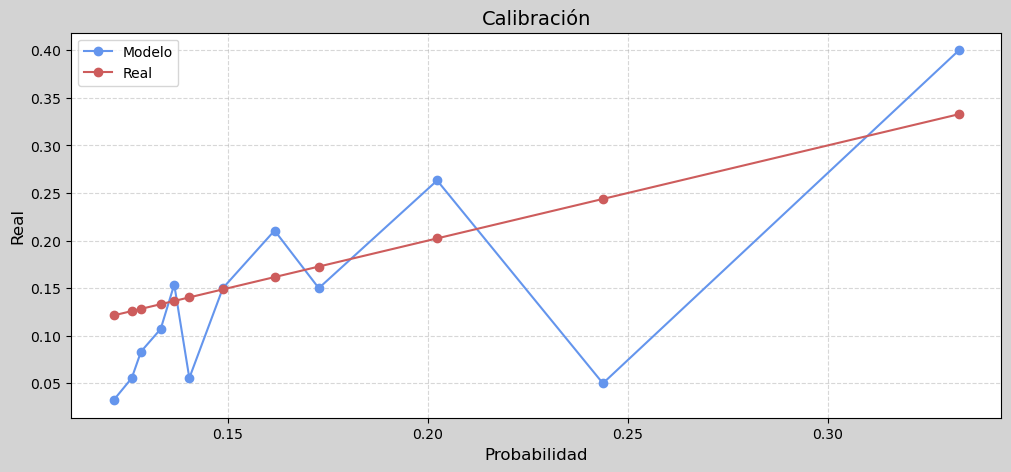

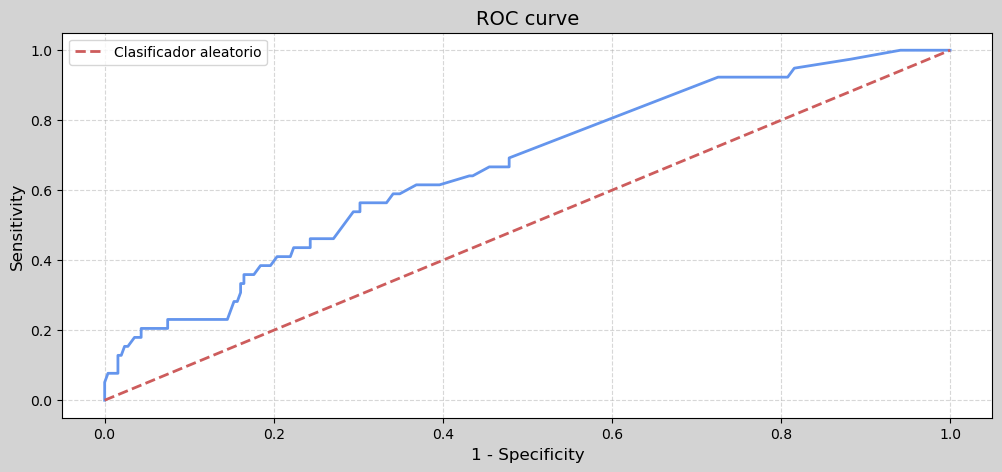

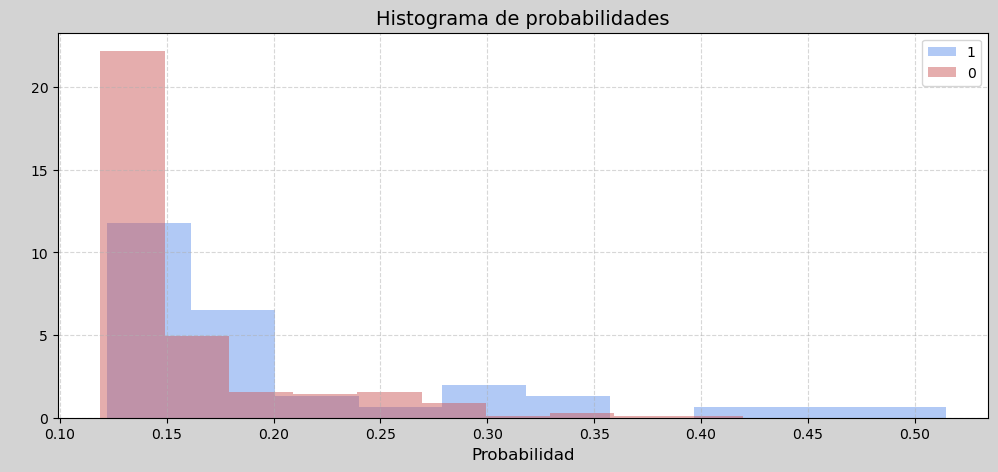

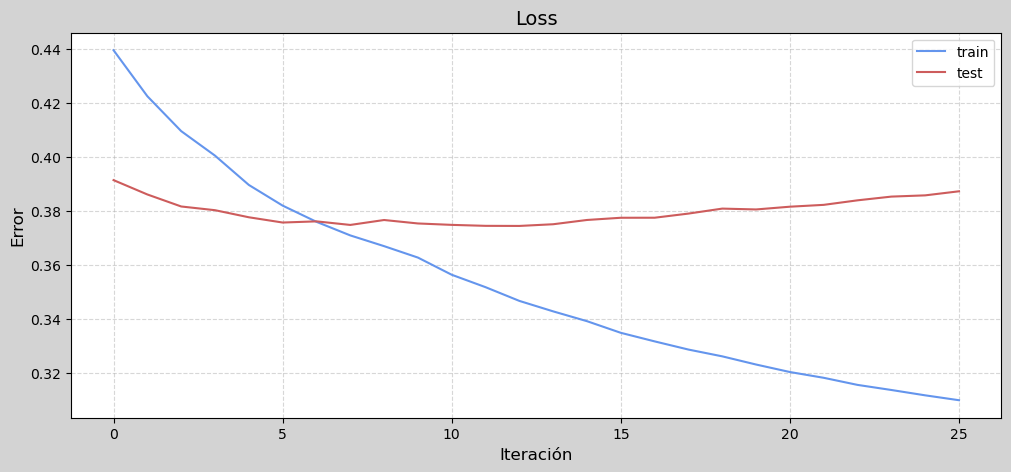

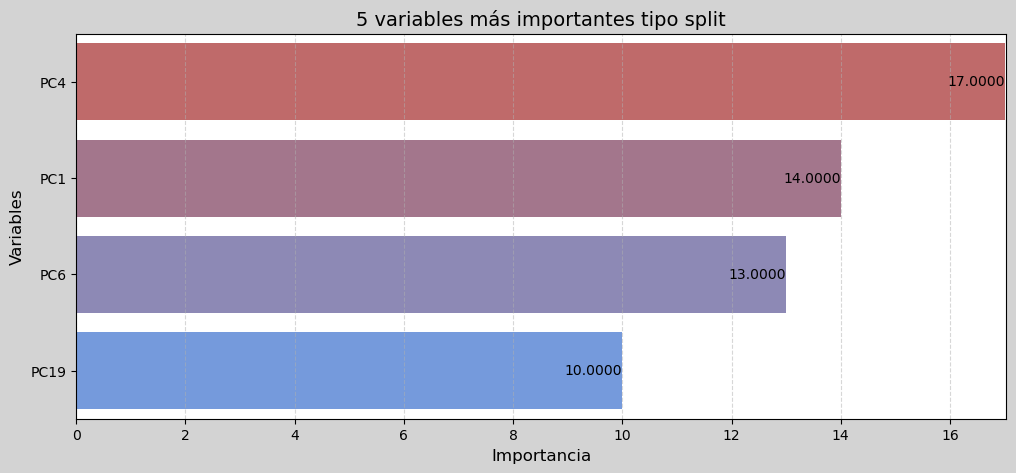

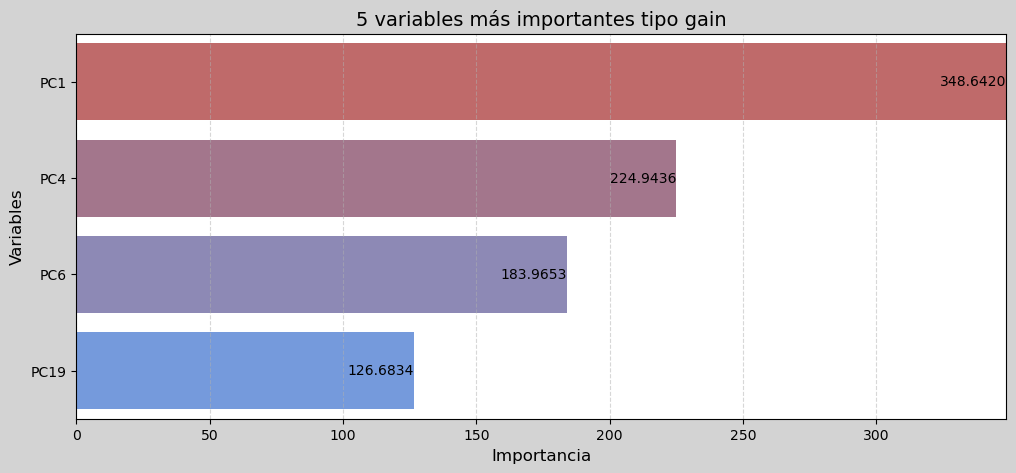

AUC: 0.6666
Gini: 0.3331


In [14]:
X_Pcomponentes = X_componentes[['PC1', 'PC6', 'PC4', 'PC19']]

XPC_train, XPC_test, y_train, y_test = train_test_split(X_Pcomponentes, y, test_size=0.2, random_state=42)

model = lightgbm(XPC_train, XPC_test, y_train, y_test)

# Parte 2 - Diabetes

## Data

In [15]:
data = pd.read_csv('Data/diabetes.csv')
data['smoking_history'] = data['smoking_history'].map({'No Info': 0, 'never': 0, 
                                                       'former': 1, 'current': 1, 'not current': 1, 'ever':1})
data = pd.get_dummies(data)
data.head()

,age,hypertension,heart_disease,smoking_history,bmi,diabetes,gender_Female,gender_Male,gender_Other
0,80.0,0,1,0,25.19,0,True,False,False
1,54.0,0,0,0,27.32,0,True,False,False
2,28.0,0,0,0,27.32,0,False,True,False
3,36.0,0,0,1,23.45,0,True,False,False
4,76.0,1,1,1,20.14,0,False,True,False


### Variable dependiente

In [16]:
target = 'diabetes'
y = data[target]

## Cross Validation

In [17]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## S learner

Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.83987	training's binary_logloss: 0.225665	valid_1's auc: 0.835881	valid_1's binary_logloss: 0.228702
Early stopping, best iteration is:
[96]	training's auc: 0.839736	training's binary_logloss: 0.225744	valid_1's auc: 0.835959	valid_1's binary_logloss: 0.228679


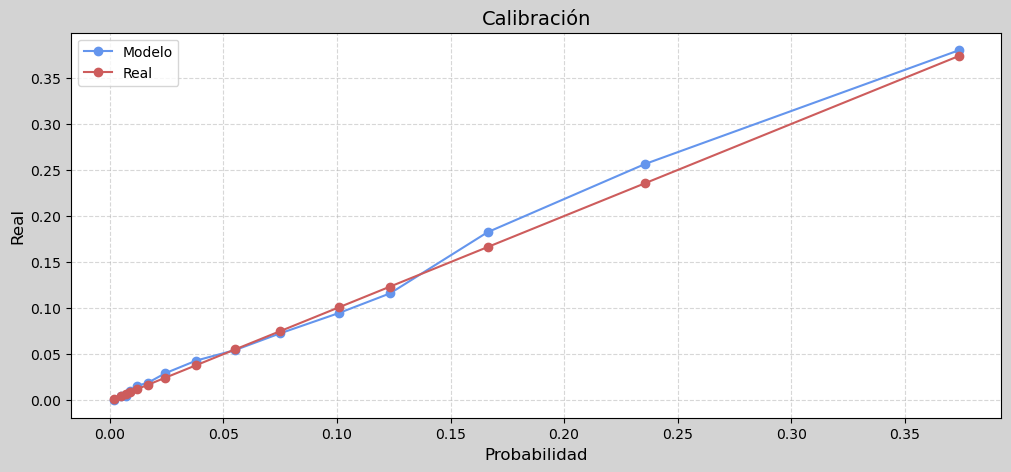

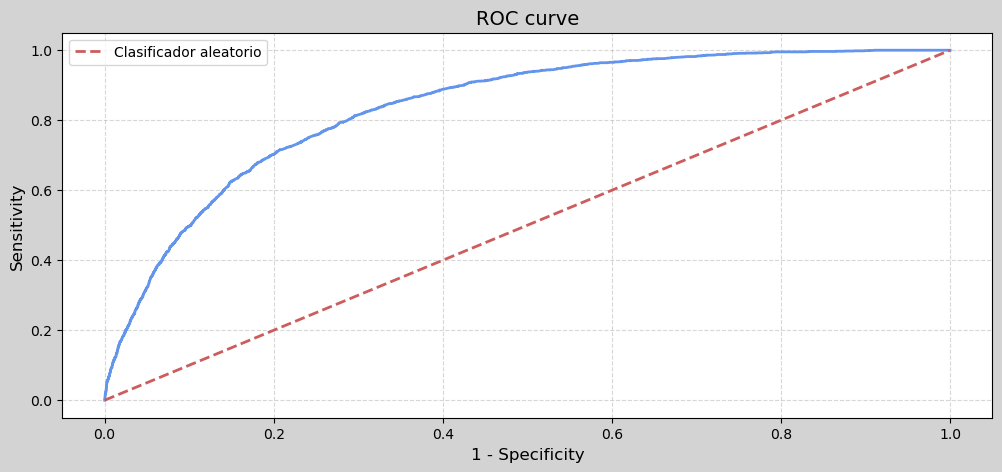

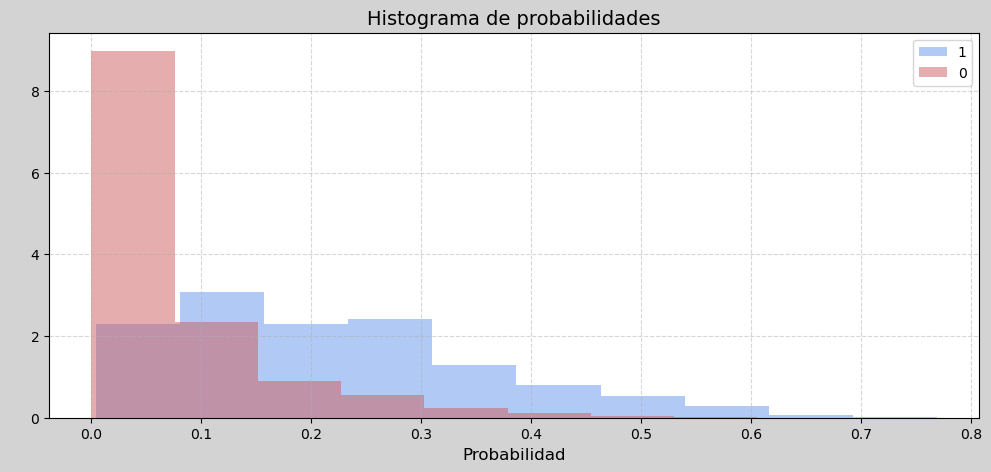

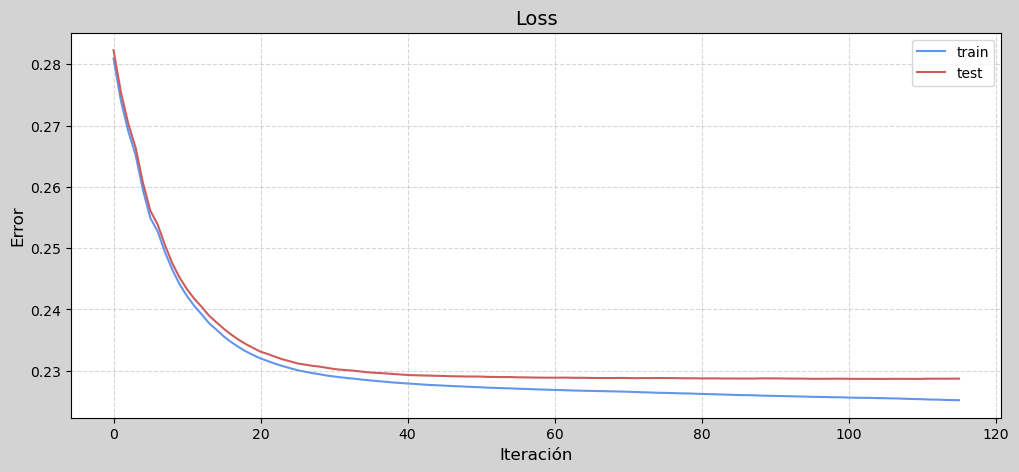

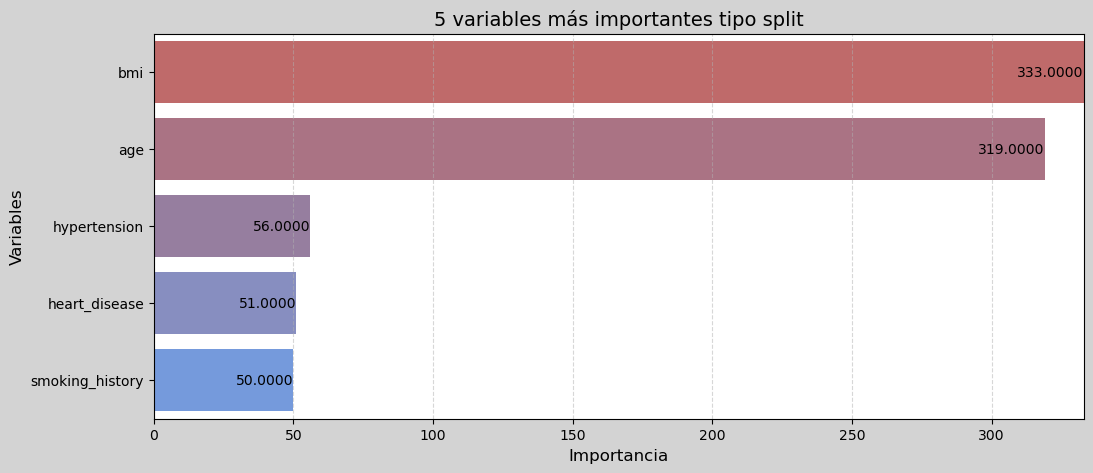

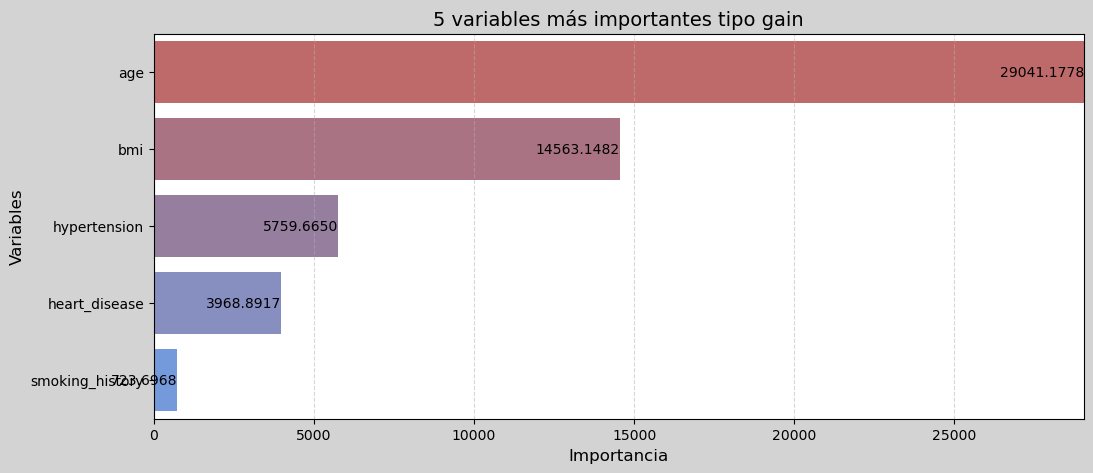

AUC: 0.8360
Gini: 0.6719


In [18]:
model = lightgbm(X_train, X_test, y_train, y_test)

In [19]:
X_test_counter0 = X_test.copy()
X_test_counter0['smoking_history'] = 0

X_test_counter1 = X_test.copy()
X_test_counter1['smoking_history'] = 1

df_cate = pd.DataFrame({
     'treatment0': model.predict_proba(X_test_counter0)[:,1],
     'treatment1': model.predict_proba(X_test_counter1)[:,1]
})
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['cate'].describe()

count    20000.000000
mean         0.016685
std          0.015422
min         -0.041742
25%          0.004668
50%          0.012854
75%          0.026239
max          0.210587
Name: cate, dtype: float64

In [20]:
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], 5, labels=False) + 1
df_cate['Diabetes_pct'] = y_test
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,Diabetes_pct
bin_cate,,,,
1,0.011332,0.012022,0.000690,0.073892
2,0.014721,0.020398,0.005677,0.091358
3,0.041414,0.053982,0.012567,0.086358
4,0.106478,0.129614,0.023136,0.106329
5,0.209648,0.251016,0.041368,0.085502


## T learner

In [21]:
X_train_smoke1 = X_train[X_train['smoking_history'] == 1]
y_train_smoke1 = y_train.loc[X_train_smoke1.index]

X_train_smoke0 = X_train[X_train['smoking_history'] == 0]
y_train_smoke0 = y_train.loc[X_train_smoke0.index]

X_test_smoke1 = X_test[X_test['smoking_history'] == 1]
y_test_smoke1 = y_test.loc[X_test_smoke1.index]

X_test_smoke0 = X_test[X_test['smoking_history'] == 0]
y_test_smoke0 = y_test.loc[X_test_smoke0.index]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	training's auc: 0.851602	training's binary_logloss: 0.189008	valid_1's auc: 0.84826	valid_1's binary_logloss: 0.194829


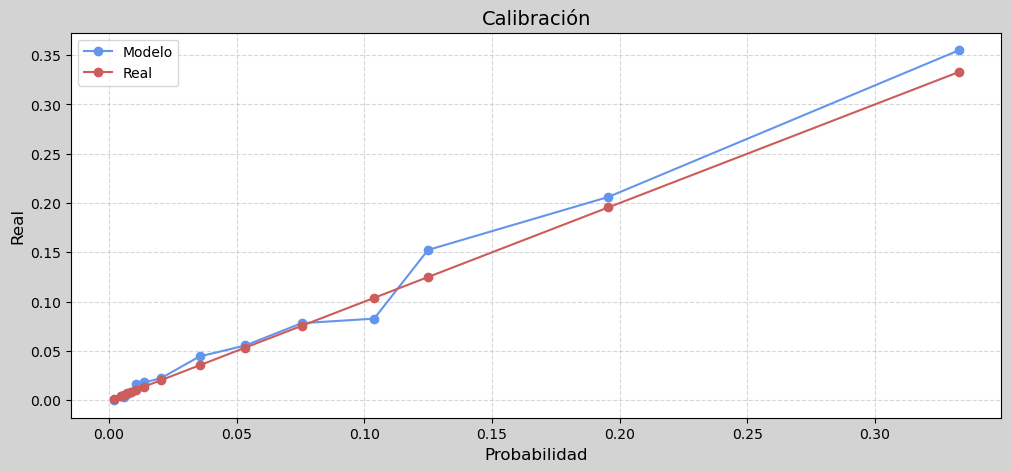

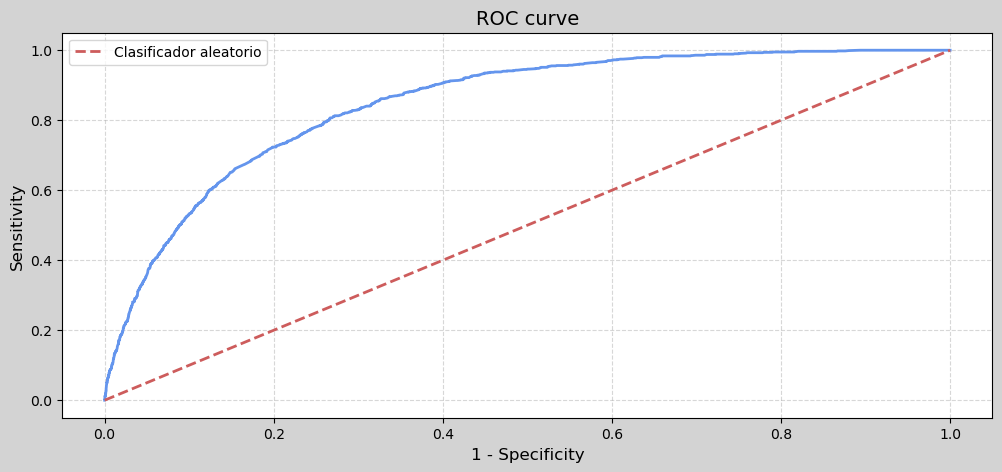

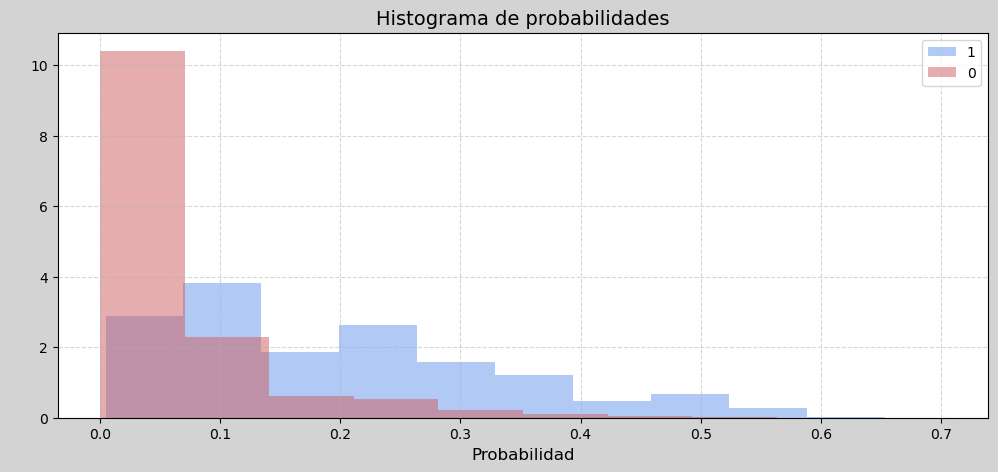

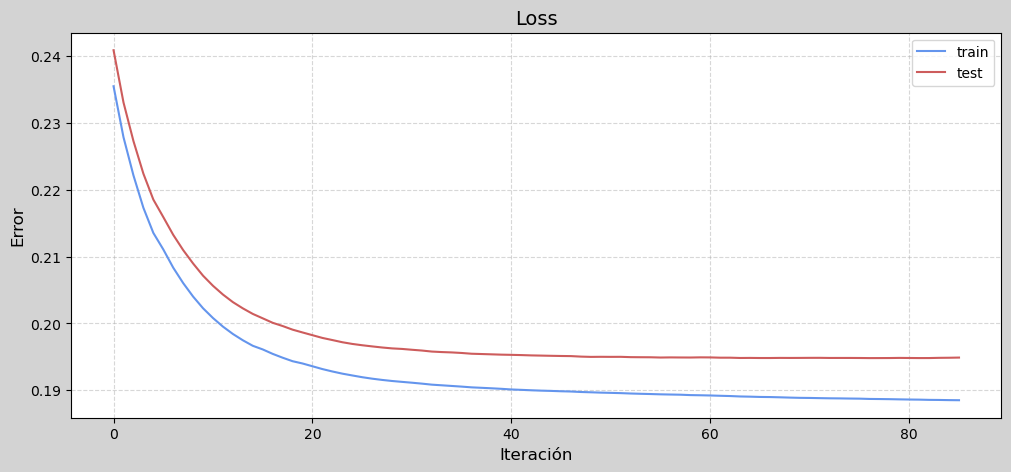

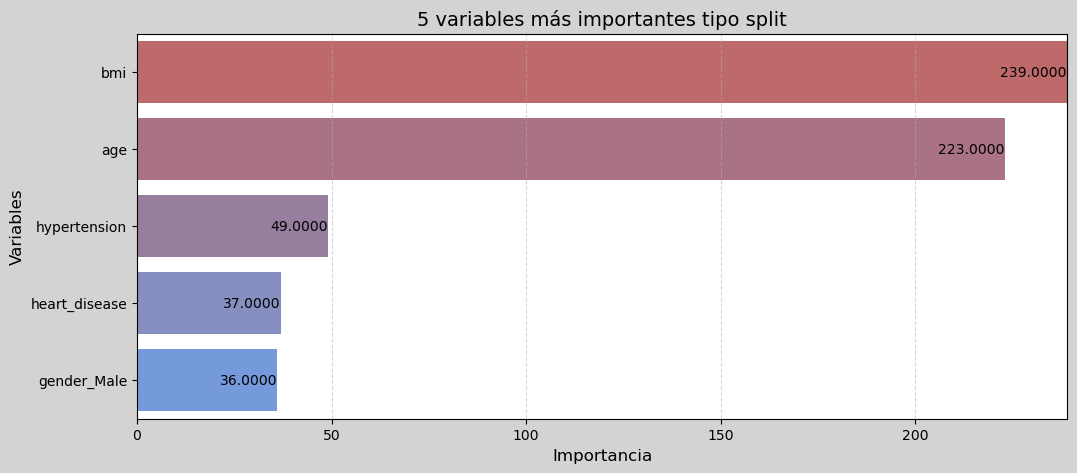

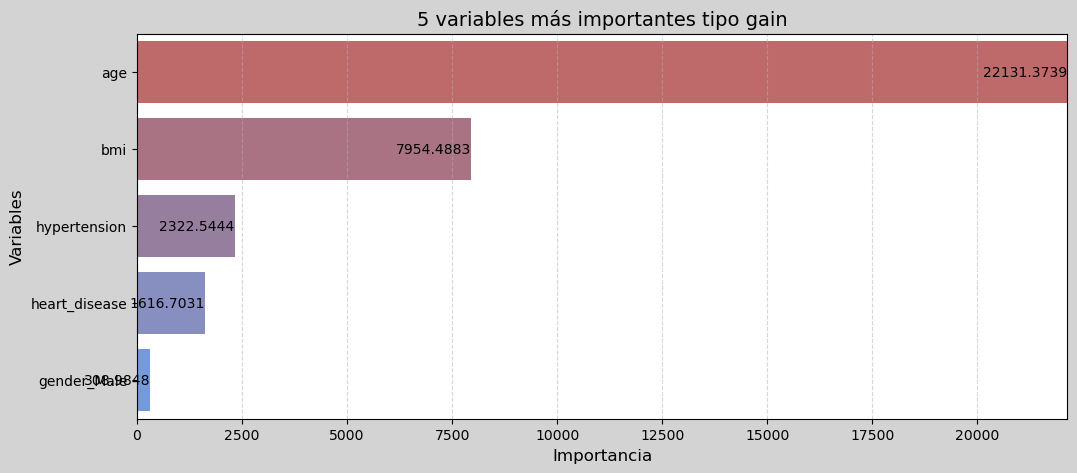

AUC: 0.8483
Gini: 0.6965


In [22]:
model_smoke0 = lightgbm(X_train_smoke0, X_test_smoke0, y_train_smoke0, y_test_smoke0)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	training's auc: 0.798495	training's binary_logloss: 0.314553	valid_1's auc: 0.794274	valid_1's binary_logloss: 0.311995


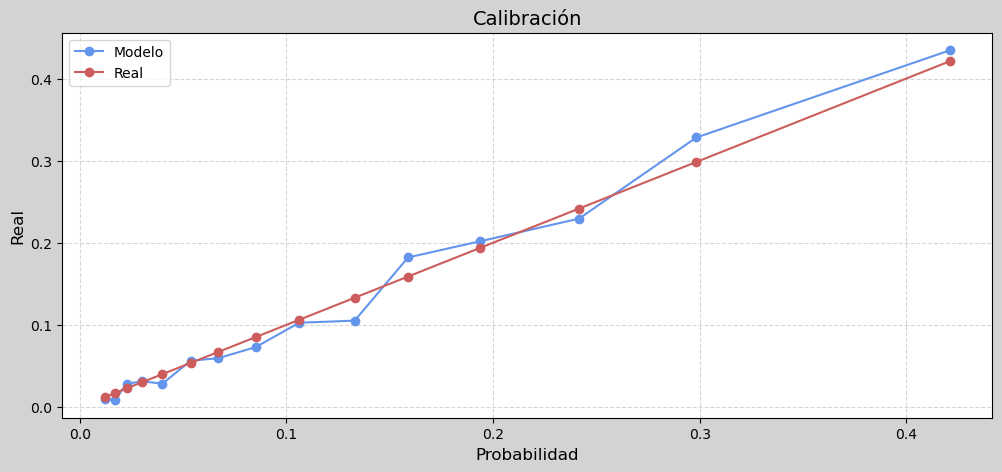

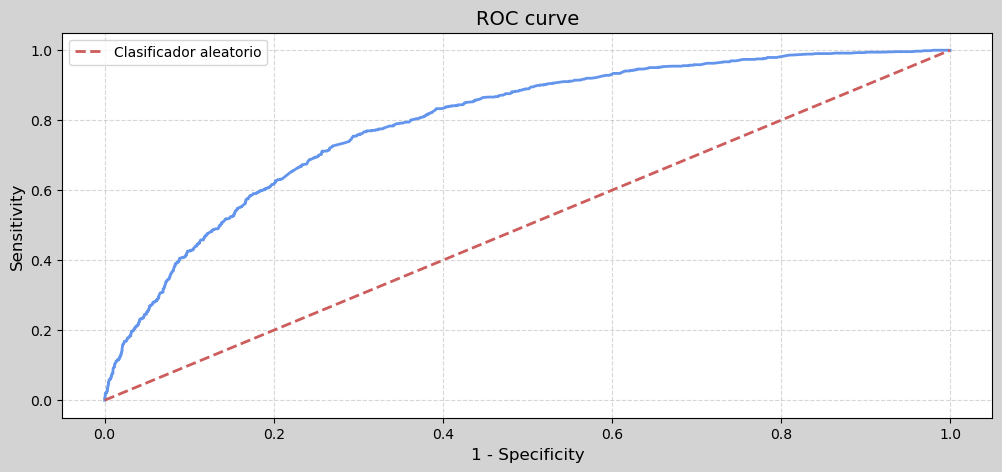

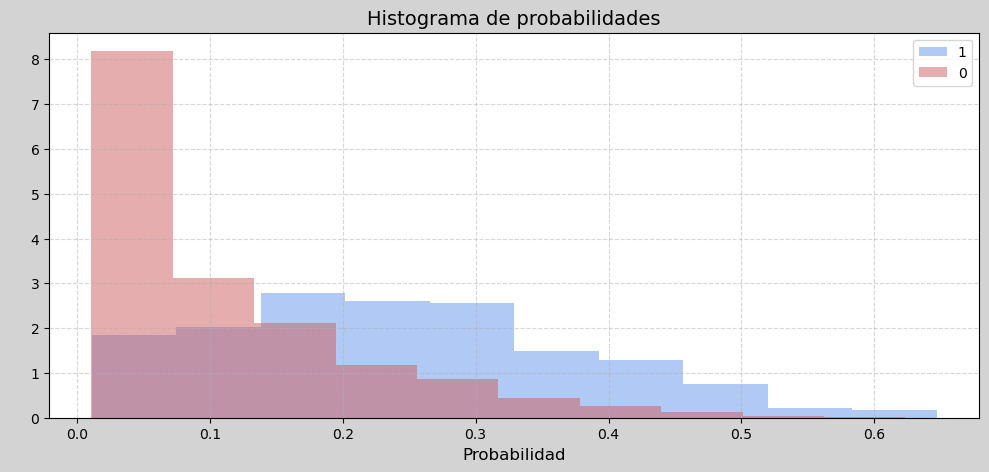

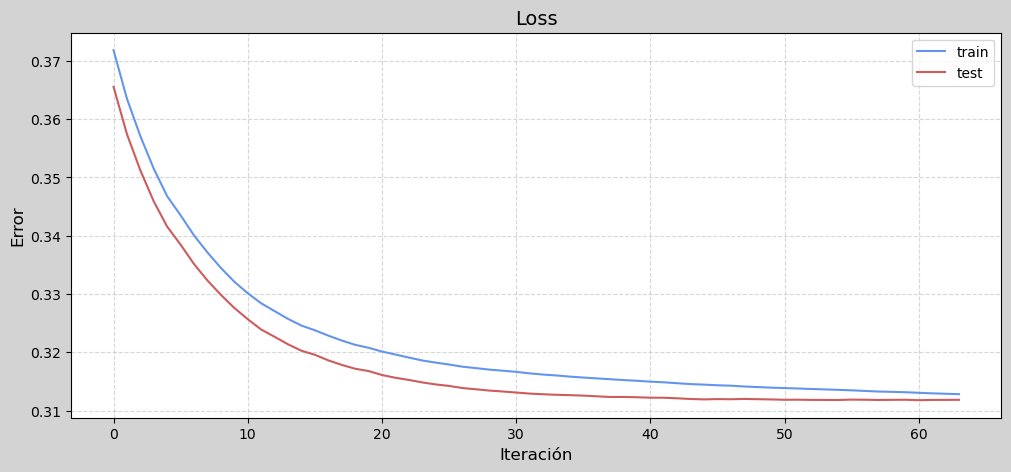

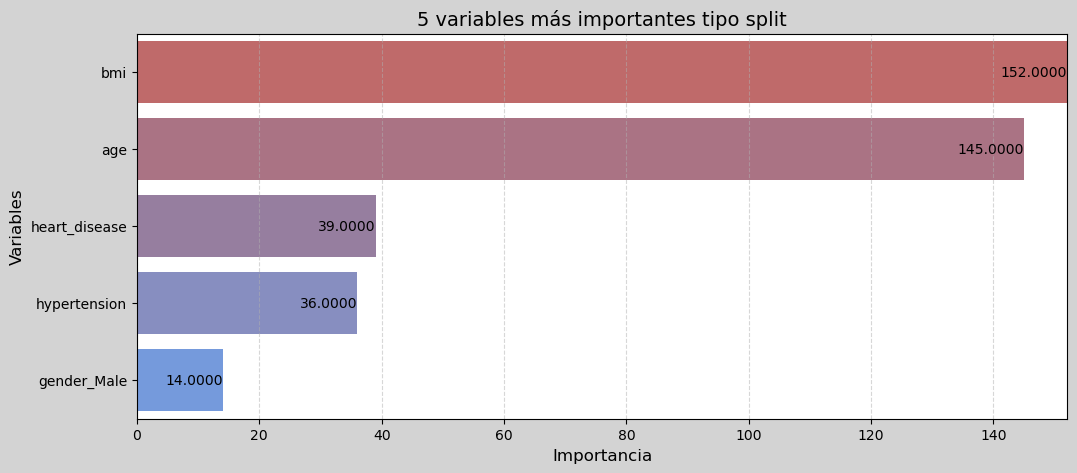

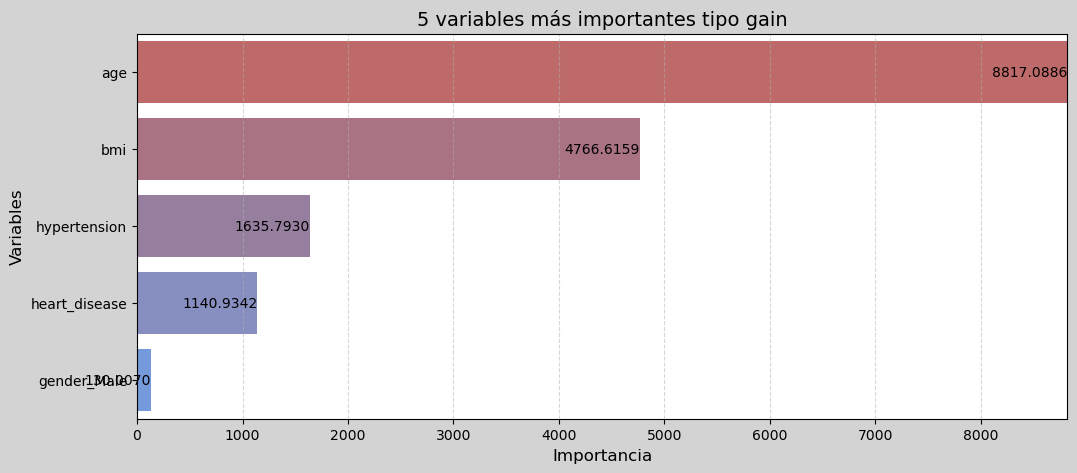

AUC: 0.7943
Gini: 0.5885


In [23]:
model_smoke1 = lightgbm(X_train_smoke1, X_test_smoke1, y_train_smoke1, y_test_smoke1)

In [24]:
todos = X_test.copy()
todos = todos[X_train_smoke0.keys()]

df_cate = pd.DataFrame({
     'treatment0': model_smoke0.predict_proba(todos)[:,1],
     'treatment1': model_smoke1.predict_proba(todos)[:,1]
})
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['cate'].describe()

count    20000.000000
mean         0.019591
std          0.026237
min         -0.304127
25%          0.006816
50%          0.012315
75%          0.027662
max          0.276982
Name: cate, dtype: float64

In [25]:
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], 5, labels=False) + 1
df_cate['Diabetes_pct'] = y_test
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,Diabetes_pct
bin_cate,,,,
1,0.088706,0.084068,-0.004638,0.095179
2,0.020790,0.028727,0.007937,0.077482
3,0.033286,0.046114,0.012828,0.078067
4,0.076895,0.100567,0.023672,0.087629
5,0.161861,0.220127,0.058266,0.105000


## X learner

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	training's auc: 0.688701	training's binary_logloss: 0.545063	valid_1's auc: 0.689113	valid_1's binary_logloss: 0.543823


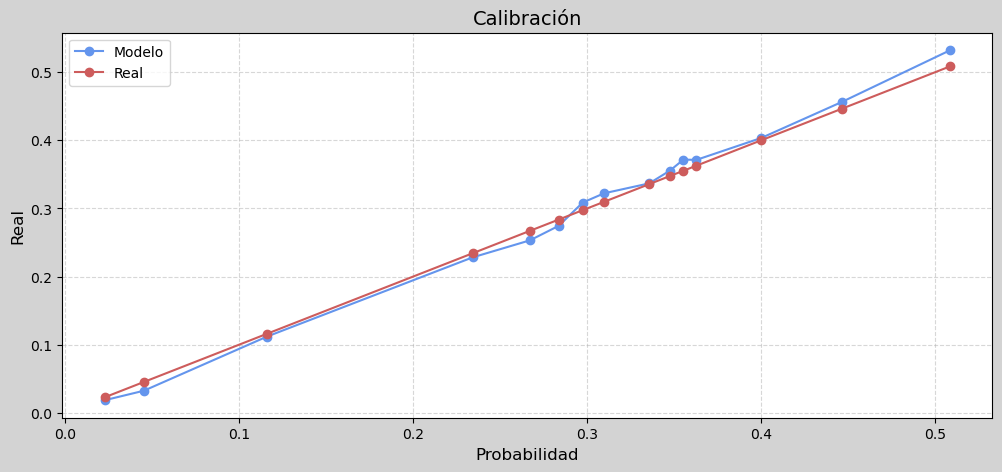

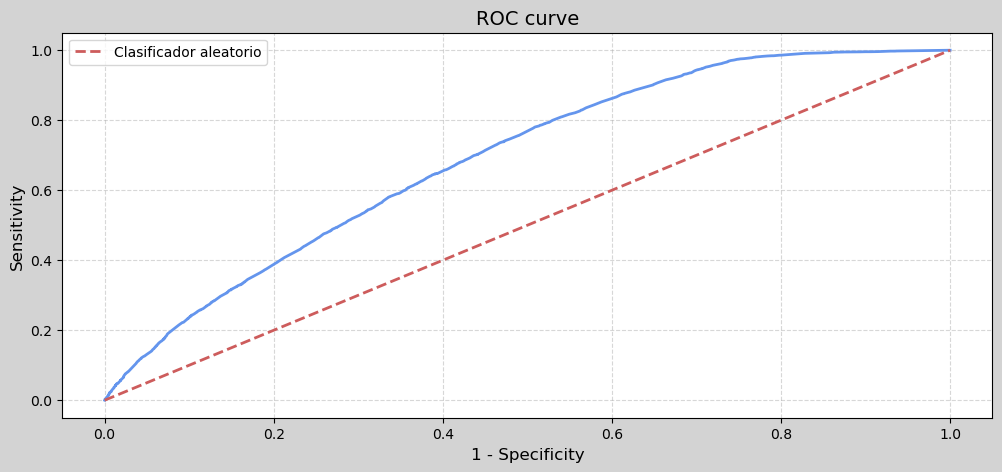

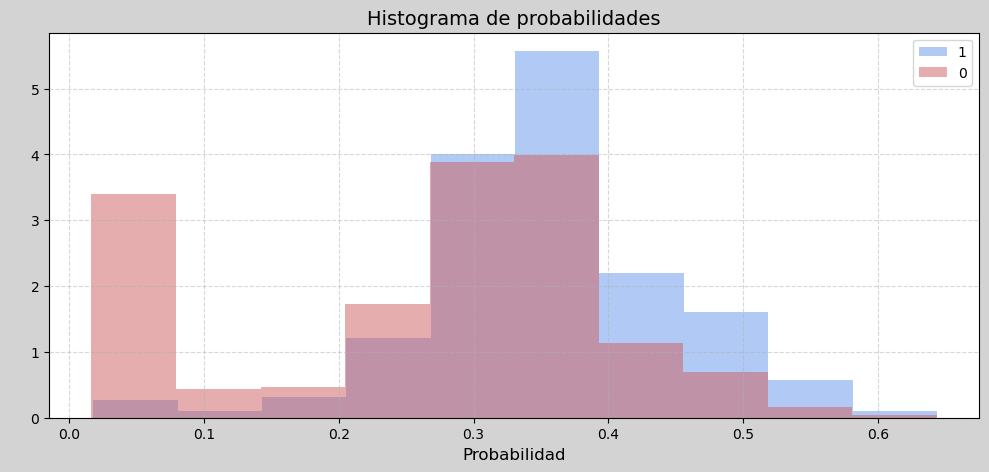

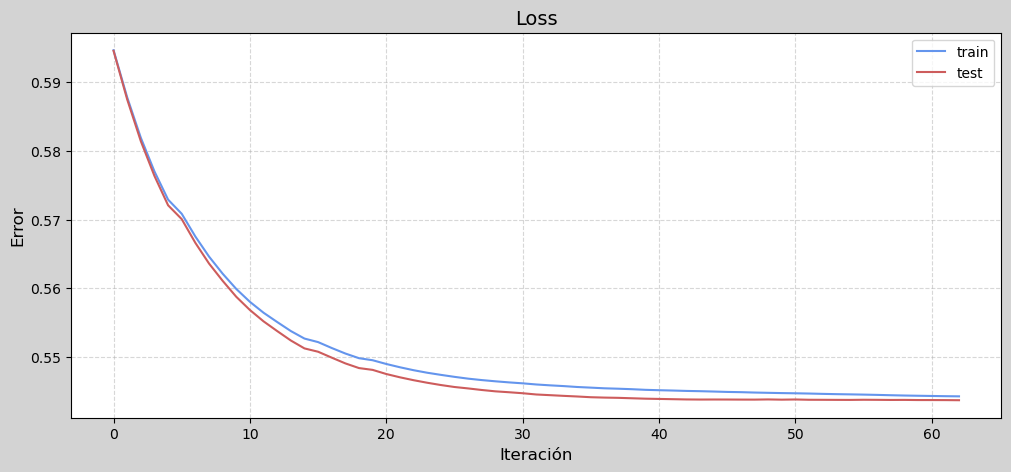

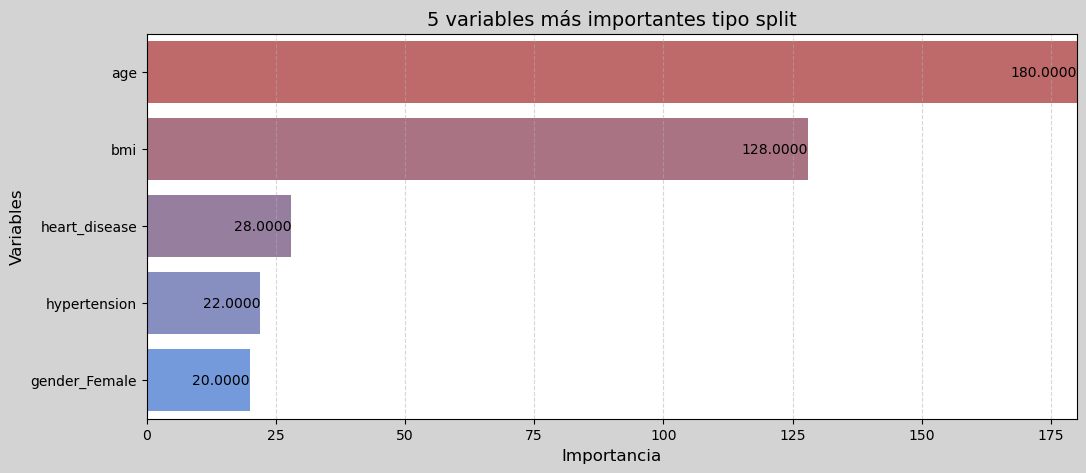

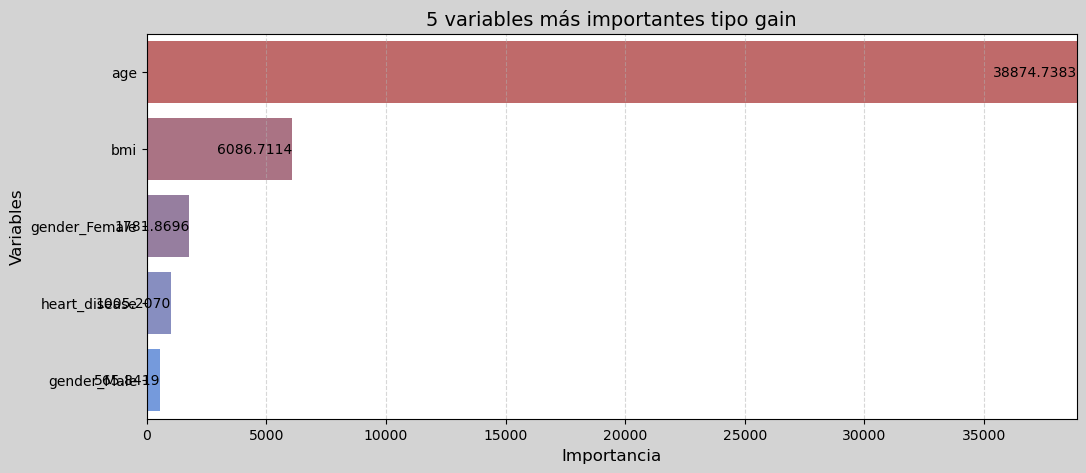

AUC: 0.6891
Gini: 0.3782


In [26]:
D0 = y_train_smoke1 - model_smoke0.predict_proba(X_train_smoke1)[:,1]
D1 = model_smoke1.predict_proba(X_train_smoke0)[:,1] - y_train_smoke0

mD0 = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1  
)
mD0.fit(X_train_smoke1, D0)

mD1 = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1
)
mD1.fit(X_train_smoke0, D1)

X_train_ps = X_train.drop('smoking_history', axis=1)
X_test_ps = X_test.drop('smoking_history', axis=1)

smoke_train = X_train['smoking_history']
smoke_test = X_test['smoking_history']

y_train_smoke = smoke_train.reset_index(drop=True)
y_test_smoke = smoke_test.reset_index(drop=True)

propensity_model = lightgbm(X_train_ps, X_test_ps, y_train_smoke, y_test_smoke)

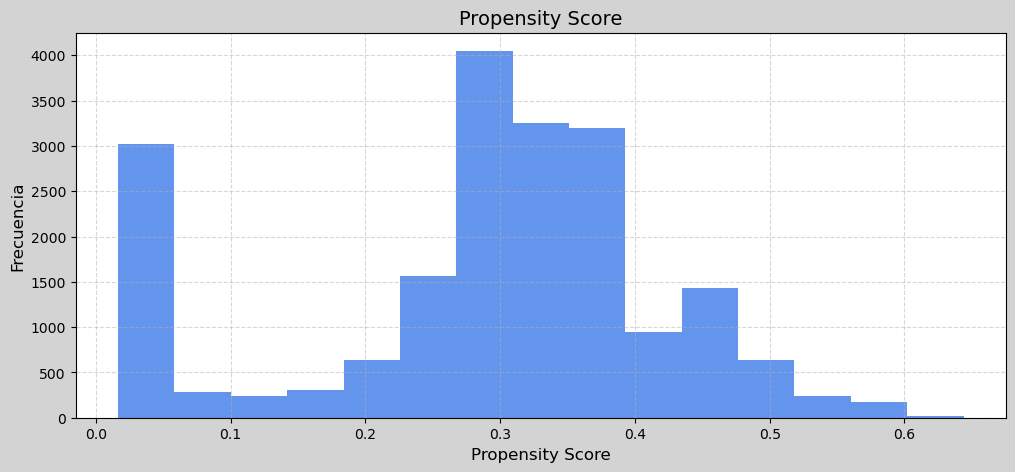

In [27]:
propensity_score = propensity_model.predict_proba(X_test_ps)[:, 1]
plt.hist(propensity_score, bins=15, color = colors[0])
plt.title('Propensity Score')
plt.xlabel('Propensity Score')
plt.ylabel('Frecuencia')
plt.show()

In [28]:
predict_d1 = mD1.predict(X_test)
predict_d0 = mD0.predict(X_test)

cate = propensity_score * predict_d1 + (1 - propensity_score) * predict_d0
df_cate = pd.DataFrame({'cate': cate})
df_cate['cate'].describe()

count    20000.000000
mean         0.018474
std          0.079939
min         -0.841539
25%         -0.011500
50%          0.006578
75%          0.038918
max          0.901310
Name: cate, dtype: float64

In [29]:
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], 5, labels=False) + 1
df_cate['Diabetes_pct'] = y_test
df_cate.groupby('bin_cate').mean()

,cate,Diabetes_pct
bin_cate,,
1,-0.066775,0.093525
2,-0.007800,0.080745
3,0.007136,0.096734
4,0.031308,0.086957
5,0.128501,0.084951
